## Backtesting the Pairs Trading Strategy (path adjustments)


,Value
Annualized Return,1.622403
Annualized Volatility,696.054388
Sharpe Ratio,0.002331
Max Drawdown,-inf


Saved net P&L to outputs/net_pnl.csv and positions to outputs/signal_positions.csv


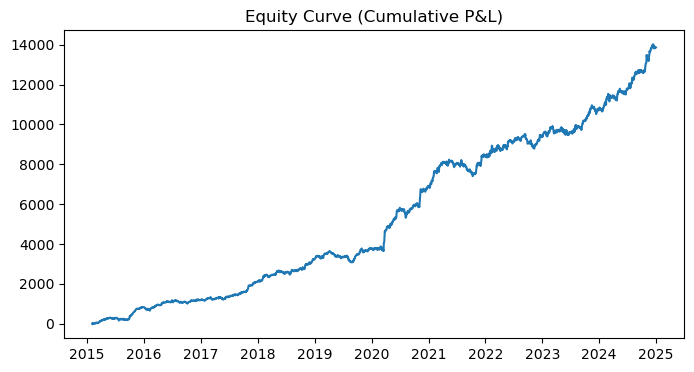

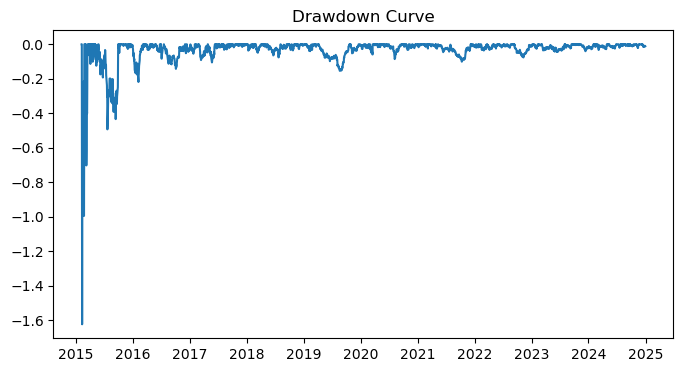

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display


# 1) Load clean price data and signals
prices = pd.read_csv("Data/sp500_prices_clean.csv", index_col=0, parse_dates=True)
signals = pd.read_csv("Output/signals.csv", index_col=0, parse_dates=True)

# Align the dates
common_dates = signals.index.intersection(prices.index)
prices = prices.loc[common_dates]
signals = signals.loc[common_dates]

# 2) Load cointegrated pairs with hedge ratios
betas = pd.read_csv("Output/cointegrated_pairs.csv")[["ticker_i", "ticker_j", "beta"]]

# 3) Compute daily P&L for each pair
daily_pnl = pd.DataFrame(index=common_dates, columns=signals.columns, dtype=float).fillna(0.0)

for _, row in betas.iterrows():
    ti, tj, beta = row.ticker_i, row.ticker_j, row.beta
    pair_col = f"{ti}_{tj}"
    if pair_col not in signals.columns:
        continue
    # Spread
    spread = prices[ti] - beta * prices[tj]
    # Change in spread
    spread_change = spread - spread.shift(1)
    # Position from previous day
    position = signals[pair_col].shift(1).fillna(0)
    # P&L
    daily_pnl[pair_col] = position * spread_change

# 4) Net portfolio P&L and transaction costs
total_pnl = daily_pnl.sum(axis=1)
tc_rate = 0.0005  # 5 bps per leg
trades = signals.diff().abs().sum(axis=1)
net_pnl = total_pnl - trades * tc_rate

# 5) Performance Metrics
trading_days = 252
cum_pnl = net_pnl.cumsum()
annual_return = (1 + cum_pnl.iloc[-1]) ** (trading_days / len(cum_pnl)) - 1
annual_vol = net_pnl.std() * np.sqrt(trading_days)
sharpe = annual_return / annual_vol
rolling_max = cum_pnl.cummax()
drawdown = (cum_pnl - rolling_max) / rolling_max
max_drawdown = drawdown.min()

metrics = pd.Series({
    "Annualized Return": annual_return,
    "Annualized Volatility": annual_vol,
    "Sharpe Ratio": sharpe,
    "Max Drawdown": max_drawdown
})

display(metrics.to_frame("Value"))

# After computing net_pnl and signals in your backtest script:

# 1) Save net P&L as a CSV for later metric analysis
net_pnl.to_frame(name="net_pnl").to_csv("Output/net_pnl.csv")

# 2) Save daily positions (if you want turnover via the utility module)
signals.to_csv("Output/signal_positions.csv")

print("Saved net P&L to outputs/net_pnl.csv and positions to outputs/signal_positions.csv")


# 6) Plotting
plt.figure(figsize=(8,4))
plt.plot(cum_pnl)
plt.title("Equity Curve (Cumulative P&L)")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(drawdown)
plt.title("Drawdown Curve")
plt.show()


<Axes: title={'center': 'Drawdown Curve (Post-Warmup, %)'}, xlabel='Date'>

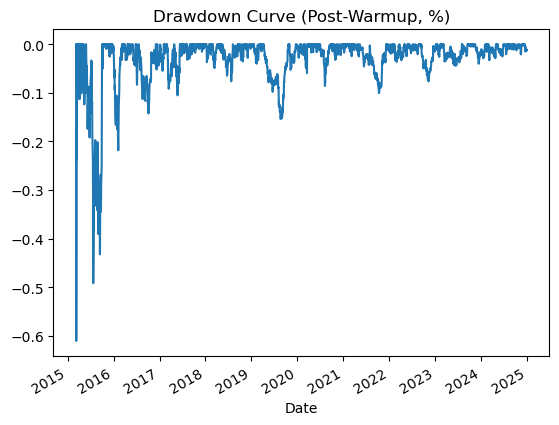

In [3]:
ROLL_WINDOW = 22  # Make sure this matches your earlier setting

# Assume $1 initial capital
starting_equity = 1.0
# Build equity curve
equity = starting_equity + net_pnl.cumsum()

# Drop the first ROLL_WINDOW days
equity = equity.iloc[ROLL_WINDOW:]

# Now compute drawdown relative to nonzero peaks
rolling_max = equity.cummax()
drawdown    = (equity - rolling_max) / rolling_max

# Plot
drawdown.plot(title="Drawdown Curve (Post-Warmup, %)")